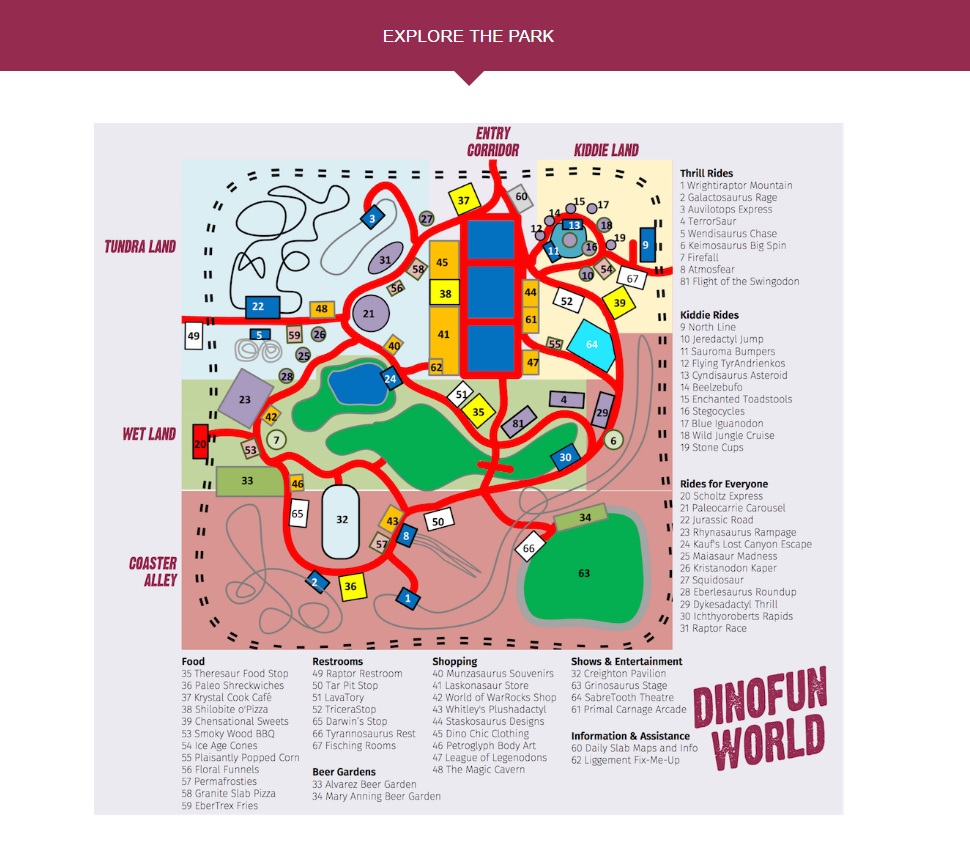

# Content
1. Initialise
<br>
2. [Abnormalities](#Abnormalities)
 - Parkgoers who did not exit at the perimeters
 - Parkgoers with multiple locations at the same Timestamp
 - Parkgoers who moved too fast
<br>
3. [Suspicious character](#Suspicious)
4. [Possible accomplices](#Accomplices)
5. [Time series](#Timeseries)

# Initialise

## Load libraries

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import networkx as nx

from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [4]:
# perimeters of Creighton Pavilion
X_MIN = 19
X_MAX = 47
Y_MIN = 14
Y_MAX = 40

def show_map(df_move):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # draw park map in grayscale
    fname = 'Park Map.jpg'
    image = Image.open(fname).convert("L")
    arr = np.asarray(image)
    ax.imshow(arr, cmap='gray', extent=[0, 100, 0, 100])
    
    ax.scatter(df_move[df_move['dino_loc']=='paths'][['X', 'Y']].drop_duplicates()['X'], df_move[df_move['dino_loc']=='paths'][['X', 'Y']].drop_duplicates()['Y'])
    ax.scatter(df_move[df_move['dino_loc']!='paths'][['X', 'Y']].drop_duplicates()['X'], df_move[df_move['dino_loc']!='paths'][['X', 'Y']].drop_duplicates()['Y'], c='r')
        
    # draw a rectangle surrounding the crime scene
    rect = patches.Rectangle((X_MIN, Y_MIN), X_MAX-X_MIN, Y_MAX-Y_MIN, linewidth=3, edgecolor='y', facecolor='none')
    ax.add_patch(rect)
    
    plt.show()

## Load files

In [5]:
comm_data_files = ['comm-data-Fri.csv',
                   'comm-data-Sat.csv', 
                   'comm-data-Sun.csv']
df_comm = pd.DataFrame()
for file in comm_data_files:
    df_comm = df_comm.append(pd.read_csv(file)).reset_index(drop=True)

df_comm = df_comm[df_comm['from']!='external']
df_comm = df_comm[df_comm['to']!='external']
df_comm['from'] = df_comm['from'].astype(int)
df_comm['to'] = df_comm['to'].astype(int)
df_comm['Timestamp'] = pd.to_datetime(df_comm['Timestamp'])
df_comm.head()

,Timestamp,from,to,location
0,2014-06-06 08:03:19,439105,1053224,Kiddie Land
1,2014-06-06 08:03:19,439105,1696241,Kiddie Land
2,2014-06-06 08:03:19,439105,580064,Kiddie Land
3,2014-06-06 08:03:19,439105,1464748,Kiddie Land
4,2014-06-06 08:03:47,1836139,1593258,Entry Corridor


In [6]:
park_movement_files = ['park-movement-Fri.csv',
                       'park-movement-Sat.csv', 
                       'park-movement-Sun.csv']
df_move = pd.DataFrame()
for file in park_movement_files:
    df_move = df_move.append(pd.read_csv(file, dtype={'id': 'str','X': 'str', 'Y': 'str'}, error_bad_lines=False))

# removed faulty row
df_move = df_move[df_move['id']!='id'].dropna().drop_duplicates().reset_index(drop=True)

df_move = df_move.astype({'X': 'int', 'Y': 'int', 'id': 'int'})
df_move['Timestamp'] = pd.to_datetime(df_move['Timestamp'])
df_move['Date'] = df_move['Timestamp'].dt.date
df_move['coord'] = '('+df_move['X'].astype(str)+','+df_move['Y'].astype(str)+')'
df_move['is_perimeter'] = False
df_move.loc[(abs(df_move['X']-0)<10)|
            (abs(df_move['X']-100)<10)|
            (abs(df_move['Y']-0)<10)|
            (abs(df_move['Y']-100)<10), 'is_perimeter']=True
df_move = df_move.sort_values(by=['id', 'Timestamp']).reset_index(drop=True)

# find possible entry and exit points
first_location = df_move.drop_duplicates(['Date', 'id'], keep='first')
first_location = first_location[first_location['is_perimeter']]
first = set(first_location['coord'])
last_location = df_move.drop_duplicates(['Date', 'id'], keep='last')
last_location = last_location[last_location['is_perimeter']]
last = set(last_location['coord'])
entry_and_exit = first.intersection(last)
print('entry and exit:', entry_and_exit)
entry_only = first.difference(last)
print('entry only:', entry_only)
exit_only = last.difference(first)
print('exit only:', exit_only)

# label the locations
dict_location = {
    '(63,99)': 'Entrance north',
    '(99,77)': 'Entrance east',
    '(0,67)': 'Entrance west',
    '(86,44)': 'Keimosaurus Big Spin',
    '(38,90)': 'Auvilotops Express',
    '(27,15)': 'Galactosaurus Rage',
    '(47,11)': 'Wrightiraptor Mountain',
    '(45,24)': 'Atmostfear',
    '(16,66)': 'Wendisaurus Chase',
    '(69,44)': 'Flight of the Swingodon',
    '(17,43)': 'Firefall',
    '(78,48)': 'TerrorSaur',
    '(32,33)': 'Creighton Pavilion',
    '(87,63)': 'SabreTooth Theatre',
    '(87,48)': 'Dykesadactyl Thrill',
    '(28,66)': 'Kristanodon Kaper',
    '(43,78)': 'Raptor Race',
    '(34,68)': 'Paleocarrie Carousel',
    '(78,37)': 'Ichthyoroberts Rapids',
    '(76,22)': 'Grinosaurus Stage',
    '(26,59)': 'Maiasaur Madness',
    '(17,67)': 'Jurassic Road',
    '(43,56)': 'Kaufs Loss Canyon Escape',
    '(6,43)': 'Scholtz Express',
    '(16,49)': 'Rhynasaurus Rampage',
    '(48,87)': 'Squidosaur',
    '(23,54)': 'Eberlesaurus Roundup',
    '(85,86)': 'Kiddie Ride',
    '(73,79)': 'Kiddie Ride',
    '(76,88)': 'Kiddie Ride',
    '(87,81)': 'Kiddie Ride',
    '(82,80)': 'Kiddie Ride',
    '(79,87)': 'Kiddie Ride',
    '(79,89)': 'Kiddie Ride',
    '(83,88)': 'Kiddie Ride',
    '(92,81)': 'Kiddie Ride',
    '(81,77)': 'Kiddie Ride',
    '(73,84)': 'Kiddie Ride',
    '(50,57)': 'Liggement Fix-Me-Up'
}
df_move['dino_loc'] = df_move['coord'].map(dict_location).fillna('paths')
df_move.head()

entry and exit: {'(63,99)', '(99,77)', '(0,67)'}
entry only: {'(7,43)', '(98,77)'}
exit only: {'(65,93)', '(63,98)', '(6,43)', '(1,67)', '(98,76)', '(64,94)', '(64,93)'}


,Timestamp,id,type,X,Y,Date,coord,is_perimeter,dino_loc
0,2014-06-08 09:48:51,436,check-in,0,67,2014-06-08,"(0,67)",True,Entrance west
1,2014-06-08 09:49:50,436,movement,1,66,2014-06-08,"(1,66)",True,paths
2,2014-06-08 09:49:58,436,movement,2,66,2014-06-08,"(2,66)",True,paths
3,2014-06-08 09:50:06,436,movement,3,66,2014-06-08,"(3,66)",True,paths
4,2014-06-08 09:50:14,436,movement,4,66,2014-06-08,"(4,66)",True,paths


# Abnormalities

## Parkgoers who did not exit at the perimeters

In [7]:
no_exits = df_move.drop_duplicates(['Date', 'id'], keep='last')[['id', 'X', 'Y', 'is_perimeter']]
no_exits = no_exits[no_exits['is_perimeter']==False].drop_duplicates().reset_index(drop=True)
display(no_exits)

for parkgoer in no_exits['id']:
    for datetime in [dt.datetime(2014,6,6,23,59), dt.datetime(2014,6,7,23,59), dt.datetime(2014,6,8,23,59)]:
        df_no_exit = df_move[(df_move['id']==parkgoer)&(df_move['Timestamp']<datetime)].tail(1)
        df_no_exit = df_no_exit[df_no_exit['is_perimeter']==False]
        if len(df_no_exit) > 0:
            display(df_no_exit)

,id,X,Y,is_perimeter
0,898576,43,56,False
1,1095309,73,20,False


,Timestamp,id,type,X,Y,Date,coord,is_perimeter,dino_loc
11147823,2014-06-08 10:19:59,898576,check-in,43,56,2014-06-08,"(43,56)",False,Kaufs Loss Canyon Escape


,Timestamp,id,type,X,Y,Date,coord,is_perimeter,dino_loc
13492826,2014-06-08 14:55:23,1095309,movement,73,20,2014-06-08,"(73,20)",False,paths


## Parkgoers with multiple locations at the same Timestamp

In [8]:
df_move = df_move.merge(df_move.groupby(['id', 'Timestamp'])['coord'].count().reset_index(name='count'), 
                        how='left', on=['id', 'Timestamp'])

df_teleported = df_move[df_move['count']>1].copy()
df_teleported.loc[(df_teleported['id']==df_teleported['id'].shift(1))&
                  (df_teleported['Timestamp']==df_teleported['Timestamp'].shift(1)), 
                  'distance'] = 0.005*(((df_teleported['X']-df_teleported['X'].shift(1))**2)+((df_teleported['Y']-df_teleported['Y'].shift(1))**2))**0.5
display(df_teleported.dropna()[['Timestamp', 'id', 'distance']].groupby('id')['distance'].mean().reset_index(name='average distance (km)'))

,id,average distance (km)
0,1600469,0.005552
1,1983765,0.115904


In [9]:
df_teleported[df_teleported['id']==1600469]['Timestamp'].dt.floor('T').value_counts()

2014-06-08 09:13:00    4
2014-06-08 09:18:00    4
2014-06-08 09:11:00    4
2014-06-08 09:03:00    2
2014-06-08 09:17:00    2
2014-06-08 09:00:00    2
2014-06-08 09:14:00    2
2014-06-08 09:10:00    2
2014-06-08 09:15:00    2
2014-06-08 09:02:00    2
2014-06-08 09:16:00    2
2014-06-08 09:07:00    2
Name: Timestamp, dtype: int64

In [10]:
df_teleported[df_teleported['id']==1983765]['Timestamp'].dt.floor('T').value_counts()

2014-06-07 20:33:00    10
2014-06-07 20:20:00    10
2014-06-07 20:22:00    10
2014-06-07 20:23:00    10
2014-06-07 20:25:00    10
2014-06-07 20:19:00    10
2014-06-07 20:27:00    10
2014-06-07 20:28:00    10
2014-06-07 20:30:00    10
2014-06-07 20:32:00    10
2014-06-07 20:26:00     8
2014-06-07 20:21:00     8
2014-06-07 20:24:00     8
2014-06-07 20:29:00     8
2014-06-07 20:31:00     8
2014-06-07 20:18:00     6
2014-06-07 20:34:00     6
Name: Timestamp, dtype: int64

### inference:
- 1600469 and 1983765 did not "teleport" together
- since the distance "teleported" by 1600469 is just 5 meters, 1600469 could just be moving fast

##  Parkgoers who moved too fast

In [11]:
df_move = df_move[df_move['count']==1]

# make every row of the same location one distinct row if the parkgoer hasnt left the location
def distinct_location(df_move):
    # if the parkgoer is still at the same location, take the previous Timestamp
    df_move.loc[(df_move['id']==df_move['id'].shift(1))&
                (df_move['X']==df_move['X'].shift(1))&
                (df_move['Y']==df_move['Y'].shift(1)), 'Timestamp'] = df_move['Timestamp'].shift(1) 
    return df_move.drop_duplicates(subset=['id', 'Timestamp', 'X', 'Y'], keep='last').reset_index(drop=True)
for i in tqdm(range(10)):
    # repeat until all locations are in one distinct row
    rows_remaining = len(df_move[(df_move['id']==df_move['id'].shift(1))&
                                 (df_move['X']==df_move['X'].shift(1))&
                                 (df_move['Y']==df_move['Y'].shift(1))])
    if rows_remaining==0:
        break
    df_move = distinct_location(df_move)
    print(i, rows_remaining)
    
# calculate the duration and speed of each person whenever they move
df_move = df_move.sort_values(by=['id', 'Timestamp']).reset_index(drop=True)
for col in ['Timestamp', 'X', 'Y']:
    df_move.loc[df_move['id']==df_move['id'].shift(-1), 'next_'+col] = df_move[col].shift(-1)
df_move = df_move.dropna()
df_move['next_X'] = df_move['next_X'].astype(int)
df_move['next_Y'] = df_move['next_Y'].astype(int)
# exclude comparison with last timestamp of the day before
df_move = df_move[df_move['Timestamp'].dt.date==df_move['next_Timestamp'].dt.date].reset_index(drop=True)
df_move['duration'] = df_move['next_Timestamp'] - df_move['Timestamp']
# distance in km
df_move['distance'] = 0.005*((((df_move['X']-df_move['next_X'])**2)+((df_move['Y']-df_move['next_Y'])**2))**0.5)
# speed in km/h
df_move['speed'] = df_move['distance']/(df_move['duration'].dt.total_seconds()/60/60)
df_move = df_move.drop(['type', 'count'], axis=1)

# World record for footspeed was 44.72 km/h, so any speed faster than 30km/h is abnormal
df_fast = df_move[df_move['speed']>30].copy()

# get the angle between the two points
def angle_between(X, Y, next_X, next_Y):
    return int(np.rad2deg(np.arctan2(next_Y-Y, next_X-X)))
df_fast['angle'] = df_fast.apply(lambda x: angle_between(x.X, x.Y, x.next_X, x.next_Y), axis=1)
df_fast

 10%|████████▎                                                                          | 1/10 [01:00<09:00, 60.06s/it]

0 324826


 20%|████████████████▌                                                                  | 2/10 [01:39<06:22, 47.76s/it]

1 10063


 30%|████████████████████████▉                                                          | 3/10 [02:13<04:49, 41.38s/it]

2 322


 40%|█████████████████████████████████▏                                                 | 4/10 [02:42<03:39, 36.56s/it]

3 10


 50%|█████████████████████████████████████████▌                                         | 5/10 [03:15<02:57, 35.52s/it]

4 3


 50%|█████████████████████████████████████████▌                                         | 5/10 [03:16<03:16, 39.31s/it]


,Timestamp,id,X,Y,Date,coord,is_perimeter,dino_loc,next_Timestamp,next_X,next_Y,duration,distance,speed,angle
2584760,2014-06-07 12:01:16,212756,14,44,2014-06-07,"(14,44)",False,paths,2014-06-07 12:01:24,99,77,0 days 00:00:08,0.455906,205.157561,21
2884992,2014-06-07 12:01:16,237750,14,44,2014-06-07,"(14,44)",False,paths,2014-06-07 12:01:24,99,77,0 days 00:00:08,0.455906,205.157561,21
9549910,2014-06-07 12:01:16,786972,14,44,2014-06-07,"(14,44)",False,paths,2014-06-07 12:01:24,99,77,0 days 00:00:08,0.455906,205.157561,21
17348715,2014-06-07 12:01:16,1421406,14,44,2014-06-07,"(14,44)",False,paths,2014-06-07 12:01:24,99,77,0 days 00:00:08,0.455906,205.157561,21
17601043,2014-06-07 12:01:17,1440397,14,44,2014-06-07,"(14,44)",False,paths,2014-06-07 12:01:24,99,77,0 days 00:00:07,0.455906,234.465784,21
18110192,2014-06-07 12:01:16,1484697,14,44,2014-06-07,"(14,44)",False,paths,2014-06-07 12:01:24,99,77,0 days 00:00:08,0.455906,205.157561,21
24239050,2014-06-07 15:06:29,1983765,47,28,2014-06-07,"(47,28)",False,paths,2014-06-07 15:06:30,75,22,0 days 00:00:01,0.143178,515.441558,-12
24239051,2014-06-07 15:06:30,1983765,75,22,2014-06-07,"(75,22)",False,paths,2014-06-07 15:06:42,48,29,0 days 00:00:12,0.139463,41.838977,165
24239052,2014-06-07 15:06:42,1983765,48,29,2014-06-07,"(48,29)",False,paths,2014-06-07 15:06:43,74,23,0 days 00:00:01,0.133417,480.299906,-12
24239053,2014-06-07 15:06:43,1983765,74,23,2014-06-07,"(74,23)",False,paths,2014-06-07 15:06:55,49,28,0 days 00:00:12,0.127475,38.242646,168


In [12]:
df_fast.groupby('angle')['id'].apply(set).reset_index()

,angle,id
0,-21,{1983765}
1,-18,{1983765}
2,-16,{1983765}
3,-15,{1983765}
4,-14,{1983765}
5,-12,{1983765}
6,-11,{1983765}
7,-10,{1983765}
8,-9,{1983765}
9,21,"{1440397, 212756, 237750, 1484697, 786972, 142..."


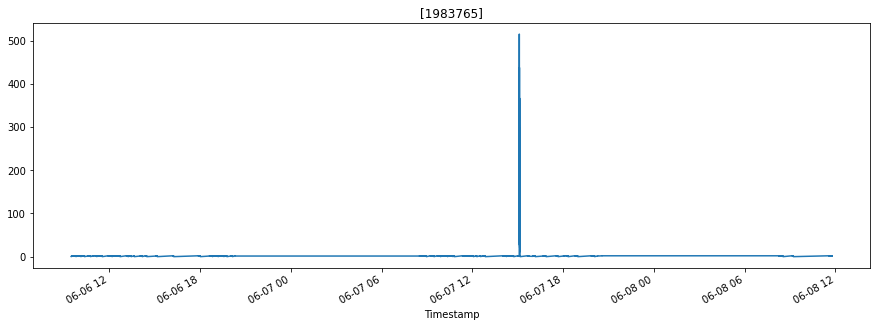

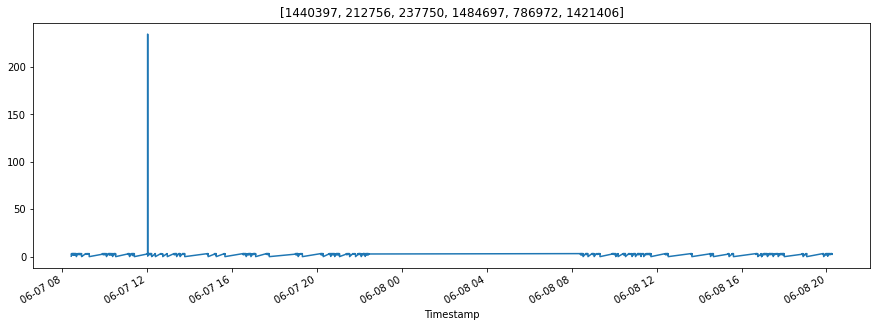

In [13]:
for grp in df_fast.groupby('angle')['id'].apply(set).reset_index()['id'].astype(str).unique():
    grp = grp.strip('{').strip('}').split(',')
    grp = [int(elem) for elem in grp]
    plt.subplots(figsize=(15, 5))
    df_move[(df_move['id'].isin(grp))].groupby('Timestamp')['speed'].mean().plot()
    plt.title(str(grp))
    plt.show()

In [14]:
df_max_speed = df_fast.sort_values(by='speed', ascending=False).drop_duplicates(subset='id').rename({'speed':'max_speed'}, axis=1).reset_index(drop=True)
df_max_speed

,Timestamp,id,X,Y,Date,coord,is_perimeter,dino_loc,next_Timestamp,next_X,next_Y,duration,distance,max_speed,angle
0,2014-06-07 15:06:29,1983765,47,28,2014-06-07,"(47,28)",False,paths,2014-06-07 15:06:30,75,22,0 days 00:00:01,0.143178,515.441558,-12
1,2014-06-07 12:01:17,1440397,14,44,2014-06-07,"(14,44)",False,paths,2014-06-07 12:01:24,99,77,0 days 00:00:07,0.455906,234.465784,21
2,2014-06-07 12:01:16,237750,14,44,2014-06-07,"(14,44)",False,paths,2014-06-07 12:01:24,99,77,0 days 00:00:08,0.455906,205.157561,21
3,2014-06-07 12:01:16,212756,14,44,2014-06-07,"(14,44)",False,paths,2014-06-07 12:01:24,99,77,0 days 00:00:08,0.455906,205.157561,21
4,2014-06-07 12:01:16,1484697,14,44,2014-06-07,"(14,44)",False,paths,2014-06-07 12:01:24,99,77,0 days 00:00:08,0.455906,205.157561,21
5,2014-06-07 12:01:16,1421406,14,44,2014-06-07,"(14,44)",False,paths,2014-06-07 12:01:24,99,77,0 days 00:00:08,0.455906,205.157561,21
6,2014-06-07 12:01:16,786972,14,44,2014-06-07,"(14,44)",False,paths,2014-06-07 12:01:24,99,77,0 days 00:00:08,0.455906,205.157561,21


### inference: 
{212756, 237750, 786972, 1421406, 1440397, 1484697} travelled at high speed together at the same angle but did not travel at a fast speed together with 1983765. 

In [15]:
set(df_teleported['id']).intersection(set(df_max_speed['id']))

{1983765}

In [16]:
display(df_comm[df_comm['from']=='1983765'])
display(df_comm[df_comm['to']=='1983765'])

,Timestamp,from,to,location


,Timestamp,from,to,location


# Suspicious
1983765 is suspicious:
 - multiple locations at same Timestamp averged 100m apart
 - maximum speed of 500km/h
 - no communication with other parkgoers

## where did 1983765 visit ?

In [17]:
df_1983765 = df_move[df_move['id']==1983765]
df_1983765 = df_1983765.merge(df_move.groupby('dino_loc')['duration'].mean(numeric_only=False).reset_index(name='average duration of other parkgoers'), 
                                          on='dino_loc', how='left').sort_values(by='duration', ascending=False).reset_index(drop=True)
df_1983765['average duration of other parkgoers'] = df_1983765['average duration of other parkgoers'].dt.floor('T')
# places where 1983765 spent longer than most parkgoers
df_1983765 = df_1983765[(df_1983765['duration']>df_1983765['average duration of other parkgoers'])&
                        (df_1983765['duration']>dt.timedelta(minutes=15))].reset_index(drop=True)
df_1983765.sort_values(by='Timestamp').reset_index(drop=True)

,Timestamp,id,X,Y,Date,coord,is_perimeter,dino_loc,next_Timestamp,next_X,next_Y,duration,distance,speed,average duration of other parkgoers
0,2014-06-06 12:42:45,1983765,69,58,2014-06-06,"(69,58)",False,paths,2014-06-06 13:05:58,69,57,0 days 00:23:13,0.005000,0.012922,0 days 00:00:00
1,2014-06-06 13:39:20,1983765,32,33,2014-06-06,"(32,33)",False,Creighton Pavilion,2014-06-06 14:01:26,32,34,0 days 00:22:06,0.005000,0.013575,0 days 00:10:00
2,2014-06-06 14:28:57,1983765,42,37,2014-06-06,"(42,37)",False,paths,2014-06-06 15:05:27,41,37,0 days 00:36:30,0.005000,0.008219,0 days 00:00:00
3,2014-06-06 15:10:39,1983765,21,33,2014-06-06,"(21,33)",False,paths,2014-06-06 16:10:34,22,34,0 days 00:59:55,0.007071,0.007081,0 days 00:00:00
4,2014-06-06 16:15:46,1983765,42,37,2014-06-06,"(42,37)",False,paths,2014-06-06 17:52:11,41,36,0 days 01:36:25,0.007071,0.004400,0 days 00:00:00
5,2014-06-06 18:01:30,1983765,78,48,2014-06-06,"(78,48)",False,TerrorSaur,2014-06-06 18:36:26,77,47,0 days 00:34:56,0.007071,0.012145,0 days 00:23:00
6,2014-06-07 08:57:58,1983765,32,33,2014-06-07,"(32,33)",False,Creighton Pavilion,2014-06-07 09:13:32,31,34,0 days 00:15:34,0.007071,0.027255,0 days 00:10:00
7,2014-06-07 10:49:16,1983765,6,43,2014-06-07,"(6,43)",True,Scholtz Express,2014-06-07 11:20:01,7,43,0 days 00:30:45,0.005000,0.009756,0 days 00:30:00
8,2014-06-07 12:51:42,1983765,69,44,2014-06-07,"(69,44)",False,Flight of the Swingodon,2014-06-07 14:00:26,68,43,0 days 01:08:44,0.007071,0.006173,0 days 00:21:00
9,2014-06-07 15:10:10,1983765,64,30,2014-06-07,"(64,30)",False,paths,2014-06-07 15:38:13,63,31,0 days 00:28:03,0.007071,0.015125,0 days 00:00:00


In [18]:
df_1983765['dino_loc'].value_counts()

paths                      7
Creighton Pavilion         4
Scholtz Express            2
Rhynasaurus Rampage        1
Flight of the Swingodon    1
Auvilotops Express         1
Atmostfear                 1
TerrorSaur                 1
Name: dino_loc, dtype: int64

In [19]:
df_1983765.groupby('dino_loc')['duration'].sum().reset_index(name='total duration').sort_values(by='total duration', ascending=False)

,dino_loc,total duration
7,paths,0 days 04:59:36
5,Scholtz Express,0 days 02:50:17
2,Creighton Pavilion,0 days 01:44:15
3,Flight of the Swingodon,0 days 01:08:44
4,Rhynasaurus Rampage,0 days 00:51:42
6,TerrorSaur,0 days 00:34:56
1,Auvilotops Express,0 days 00:26:45
0,Atmostfear,0 days 00:20:34


In [20]:
df_1983765[df_1983765['dino_loc']=='Creighton Pavilion'].sort_values(by='Timestamp').reset_index(drop=True)

,Timestamp,id,X,Y,Date,coord,is_perimeter,dino_loc,next_Timestamp,next_X,next_Y,duration,distance,speed,average duration of other parkgoers
0,2014-06-06 13:39:20,1983765,32,33,2014-06-06,"(32,33)",False,Creighton Pavilion,2014-06-06 14:01:26,32,34,0 days 00:22:06,0.005000,0.013575,0 days 00:10:00
1,2014-06-07 08:57:58,1983765,32,33,2014-06-07,"(32,33)",False,Creighton Pavilion,2014-06-07 09:13:32,31,34,0 days 00:15:34,0.007071,0.027255,0 days 00:10:00
2,2014-06-07 16:09:59,1983765,32,33,2014-06-07,"(32,33)",False,Creighton Pavilion,2014-06-07 16:40:54,32,34,0 days 00:30:55,0.005000,0.009704,0 days 00:10:00
3,2014-06-08 08:32:38,1983765,32,33,2014-06-08,"(32,33)",False,Creighton Pavilion,2014-06-08 09:08:18,31,34,0 days 00:35:40,0.007071,0.011895,0 days 00:10:00


1983765 visited Creighton Pavilion 4 times, with the last time on 2014-06-08 lasting 35 minutes, from 0832hrs to 0908hrs

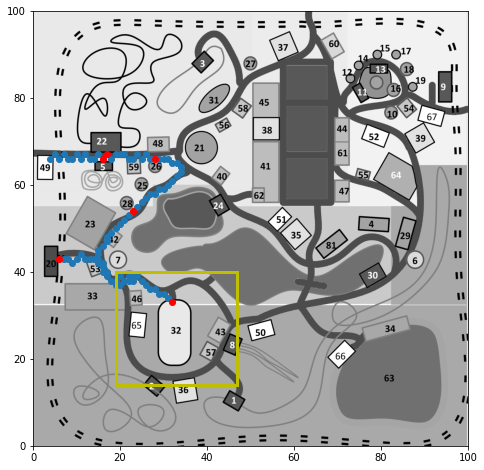

In [21]:
# location of 1983765 15 minutes before and after visiting Creighton Pavilion
show_map(df_move[(df_move['Timestamp']>=dt.datetime(2014,6,8,8,32)-dt.timedelta(minutes=15))&
                 (df_move['Timestamp']<=dt.datetime(2014,6,8,9,8)+dt.timedelta(minutes=15))&
                 (df_move['id']==1983765)])

# Accomplices
Find other parkgoers who had time overlaps with 1983765

In [22]:
def find_accomplice(target=1983765, X=32, Y=33, 
                    time_start=dt.datetime(2014,6,8,8,0), 
                    time_end=dt.datetime(2014,6,8,10,0), 
                    min_time = dt.timedelta(minutes=15), suffix=''):

    df_move_incident = df_move[(df_move['Timestamp']>=time_start)&(df_move['Timestamp']<=time_end)&
                               (df_move['X']==X)&(df_move['Y']==Y)][['id', 'Timestamp', 'next_Timestamp']].drop_duplicates()
                
    possible_acmpl = []
    df_target = df_move_incident[df_move_incident['id']==target].reset_index(drop=True)
    for i in range(len(df_target)):
        START_target = df_target['Timestamp'][i]
        END_target = df_target['next_Timestamp'][i]

        for acmpl in (df_move_incident[df_move_incident['id']!=target]['id'].unique()):
            df_acmpl = df_move_incident[df_move_incident['id']==acmpl].reset_index(drop=True)
            for i, START_acmpl in enumerate(df_acmpl['Timestamp']):
                END_acmpl = df_acmpl['next_Timestamp'][i]
                time_overlap = min(END_target, END_acmpl) - max(START_target, START_acmpl)
                if time_overlap > dt.timedelta(minutes=0):
                    possible_acmpl.append([acmpl, time_overlap])
    possible_acmpl = pd.DataFrame(possible_acmpl, columns=['id', 'time_overlap_'+suffix])
    return possible_acmpl[possible_acmpl['time_overlap_'+suffix]>min_time].sort_values(by='time_overlap_'+suffix, ascending=False).reset_index(drop=True)

## Time overlap at Creighton Pavilion

In [23]:
accomplice_crime = find_accomplice(time_start=dt.datetime(2014,6,8,8,32)-dt.timedelta(minutes=15), 
                                   time_end=dt.datetime(2014,6,8,9,8)+dt.timedelta(minutes=15),
                                   suffix='crime')
accomplice_crime

,id,time_overlap_crime
0,423861,0 days 00:35:40
1,1877839,0 days 00:35:40
2,1643608,0 days 00:35:40
3,1379586,0 days 00:35:40
4,2090048,0 days 00:35:14
...,...,...
250,1008236,0 days 00:15:05
251,1386541,0 days 00:15:05
252,1180630,0 days 00:15:04
253,105229,0 days 00:15:04


## Time overlap at other locations

In [24]:
# find parkgoers with high time overlap with 1983765 +- 15 minutes
df_accomplices = df_max_speed[['id', 'max_speed']].reset_index(drop=True)
for i in range(len(df_1983765)):
    df_accomplices = df_accomplices.merge(
        find_accomplice(X=df_1983765['X'][i], 
                        Y=df_1983765['Y'][i], 
                        time_start=df_1983765['Timestamp'][i]-dt.timedelta(minutes=15), 
                        time_end=df_1983765['next_Timestamp'][i]+dt.timedelta(minutes=15), 
                        suffix='('+str(df_1983765['X'][i])+','+str(df_1983765['Y'][i])+')_'+str(df_1983765['Timestamp'][i])),
        on='id', how='outer')
time_overlap_Col = [col for col in df_accomplices.columns if 'time_overlap' in col]
df_accomplices['total_time'] = df_accomplices[time_overlap_Col].fillna(dt.timedelta(seconds=0)).sum(axis=1)
df_accomplices = df_accomplices[df_accomplices['total_time']>dt.timedelta(seconds=0)]
accomplice_crime = accomplice_crime.merge(df_accomplices, on='id', how='inner')

for col in time_overlap_Col:
    accomplice_crime = accomplice_crime.drop(col, axis=1)
accomplice_crime = accomplice_crime.dropna(axis=1, how='all')

## Filter to those who do not use park communication
Since 1983765 did not use the park communication, his accomplices are unlikely to use it too

In [25]:
# exclude those who communicated within the shortlisted parkgoers
df_comm_aggregated = df_comm.groupby(['from', 'to']).size().sort_values(ascending=False).reset_index(name='count')
df_comm_aggregated = df_comm_aggregated[df_comm_aggregated['from'].isin(accomplice_crime['id'])]
df_comm_aggregated = df_comm_aggregated[df_comm_aggregated['to'].isin(accomplice_crime['id'])]
G = nx.from_pandas_edgelist(df_comm_aggregated, 'from', 'to', 'count', create_using=nx.DiGraph)

# set default to '-'
accomplice_crime['Comm_Group_within_suspects'] = '-'
group = 1
for c in nx.strongly_connected_components(G):
    if len(c) > 1:
        accomplice_crime.loc[accomplice_crime['id'].isin(c), 'Comm_Group_within_suspects'] = 'CommGroup_'+str(group)
        group += 1
# exclude '-' from value_counts() calculation
accomplice_crime = accomplice_crime.merge(accomplice_crime[accomplice_crime['Comm_Group_within_suspects']!='-']['Comm_Group_within_suspects'].value_counts().reset_index().rename({'Comm_Group_within_suspects':'Comm_with_suspects'}, axis=1).rename({'index':'Comm_Group_within_suspects'}, axis=1), how='left', on='Comm_Group_within_suspects')
accomplice_crime['Comm_with_suspects'] = accomplice_crime['Comm_with_suspects']-1
accomplice_crime['Comm_with_suspects'] = accomplice_crime['Comm_with_suspects'].fillna(0)
accomplice_crime = accomplice_crime[accomplice_crime['Comm_with_suspects']==0]

# exclude those who communicated with other parkgoers
def get_comm(person):
    return df_comm[(df_comm['from']==person)&(~df_comm['to'].isin(accomplice_crime['id']))]['to'].nunique()
accomplice_crime['Comm_to_non_suspects'] = accomplice_crime['id'].apply(lambda x: get_comm(x))
accomplice_crime['Comm_to_non_suspects'] = accomplice_crime['Comm_to_non_suspects'].fillna(0)
accomplice_crime = accomplice_crime[accomplice_crime['Comm_to_non_suspects']==0]

# drop columns which are all empty
accomplice_crime = accomplice_crime.dropna(axis=1, how='all')
accomplice_crime = accomplice_crime.drop(['Comm_Group_within_suspects', 'Comm_with_suspects', 'Comm_to_non_suspects'], axis=1)

## assume culprit will not attend Scott Jones shows at (76,22), 9:30 – 11:30 and 14:30 – 16:30
- arrive not more than 30min before show starts
- arrive less than 30min before show ends
- spends at least 1 hours there

In [26]:
show_goers = pd.concat([df_move[(df_move['Timestamp']>=dt.datetime(2014,6,6,9,0))&(df_move['Timestamp']<=dt.datetime(2014,6,6,10,30))],
                        df_move[(df_move['Timestamp']>=dt.datetime(2014,6,7,9,0))&(df_move['Timestamp']<=dt.datetime(2014,6,7,10,30))],
                        df_move[(df_move['Timestamp']>=dt.datetime(2014,6,6,14,0))&(df_move['Timestamp']<=dt.datetime(2014,6,6,15,30))],
                        df_move[(df_move['Timestamp']>=dt.datetime(2014,6,7,14,0))&(df_move['Timestamp']<=dt.datetime(2014,6,7,15,30))]
                       ])
show_goers = show_goers[(show_goers['dino_loc']=='Grinosaurus Stage')&(show_goers['duration']>=dt.timedelta(hours=1))]

assert 1983765 not in show_goers['id'].unique()
accomplice_crime = accomplice_crime[~accomplice_crime['id'].isin(show_goers['id'].unique())].reset_index(drop=True)

## comparing their route taken with that of 1983765 15 minutes before and after 1983765 visited Creighton Pavilion

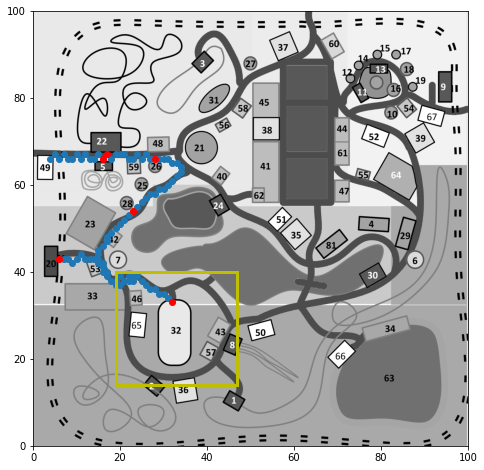

In [27]:
show_map(df_move[(df_move['Timestamp']>=dt.datetime(2014,6,8,8,32)-dt.timedelta(minutes=15))&
                 (df_move['Timestamp']<=dt.datetime(2014,6,8,9,8)+dt.timedelta(minutes=15))&
                 (df_move['id']==1983765)])

In [28]:
def route_similarity(suspect, 
                     time_start=dt.datetime(2014,6,8,8,32)-dt.timedelta(minutes=15), 
                     time_end=dt.datetime(2014,6,8,9,8)+dt.timedelta(minutes=15)):
    route_target = set(df_move[(df_move['Timestamp']>=time_start)&
                     (df_move['Timestamp']<=time_end)&
                     (df_move['id']==1983765)]['coord'])
    route_suspect = set(df_move[(df_move['Timestamp']>=time_start)&
                     (df_move['Timestamp']<=time_end)&
                     (df_move['id']==suspect)]['coord'])
    return np.round(len(route_target.intersection(route_suspect))/len(route_target),3)

def location_similarity(suspect, 
                     time_start=dt.datetime(2014,6,8,8,32)-dt.timedelta(minutes=15), 
                     time_end=dt.datetime(2014,6,8,9,8)+dt.timedelta(minutes=15)):
    location_target = set(df_move[(df_move['Timestamp']>=time_start)&
                     (df_move['Timestamp']<=time_end)&
                     (df_move['id']==1983765)]['dino_loc'])
    location_suspect = set(df_move[(df_move['Timestamp']>=time_start)&
                     (df_move['Timestamp']<=time_end)&
                     (df_move['id']==suspect)]['dino_loc'])
    return np.round(len(location_target.intersection(location_suspect))/len(location_target),3)

accomplice_crime['route_similarity'] = accomplice_crime['id'].apply(lambda x: route_similarity(x))
accomplice_crime['location_similarity'] = accomplice_crime['id'].apply(lambda x: location_similarity(x))
accomplice_crime.sort_values(by='route_similarity', ascending=False)

# combine everything into rank
accomplice_crime['rank'] = (accomplice_crime['time_overlap_crime'].rank(pct=True)+
                            accomplice_crime['total_time'].rank(pct=True)+
                            accomplice_crime['route_similarity'].rank(pct=True)+
                            accomplice_crime['location_similarity'].rank(pct=True))/4
accomplice_crime = accomplice_crime.sort_values(by='rank', ascending=False).reset_index(drop=True)
accomplice_crime[['id', 'time_overlap_crime', 'total_time', 'route_similarity', 'location_similarity', 'rank']]

,id,time_overlap_crime,total_time,route_similarity,location_similarity,rank
0,2096121,0 days 00:28:37,0 days 00:49:35,0.375,0.429,0.851974
1,937009,0 days 00:28:50,0 days 00:28:50,0.455,0.429,0.828947
2,27774,0 days 00:18:39,0 days 00:45:55,0.489,0.429,0.789474
3,1718690,0 days 00:18:39,0 days 00:45:54,0.455,0.429,0.773026
4,1077662,0 days 00:26:17,0 days 00:26:17,0.432,0.429,0.759868
5,1368768,0 days 00:35:14,0 days 00:35:14,0.080,0.286,0.651316
6,2090048,0 days 00:35:14,0 days 00:35:14,0.068,0.286,0.641447
7,1748756,0 days 00:35:14,0 days 00:35:14,0.068,0.286,0.641447
8,723424,0 days 00:21:56,0 days 00:21:56,0.227,0.429,0.601974
9,540855,0 days 00:29:47,0 days 00:29:47,0.023,0.286,0.562500


# Timeseries

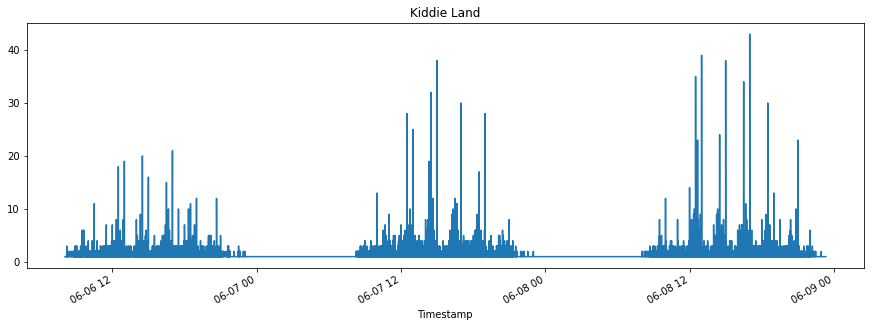

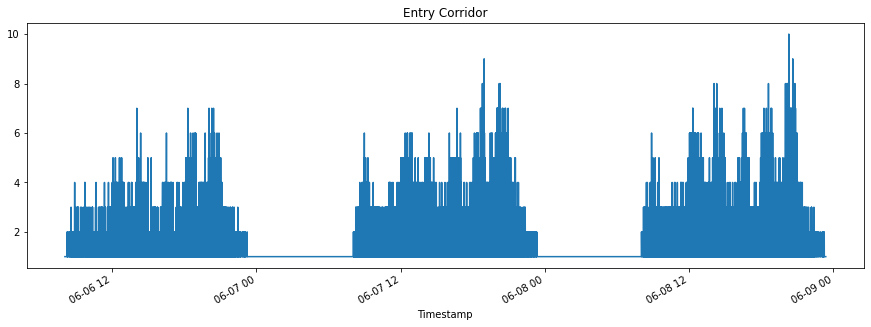

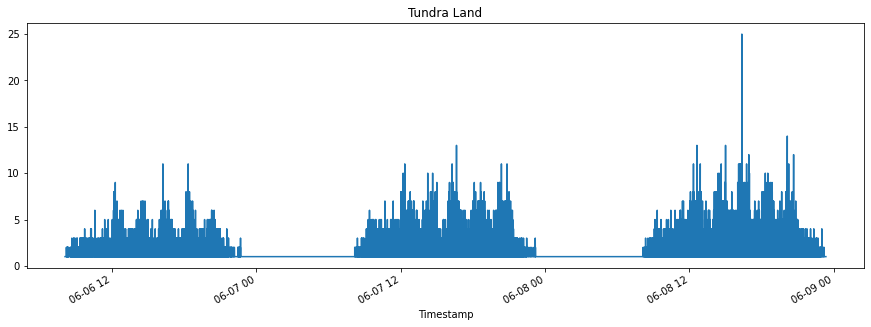

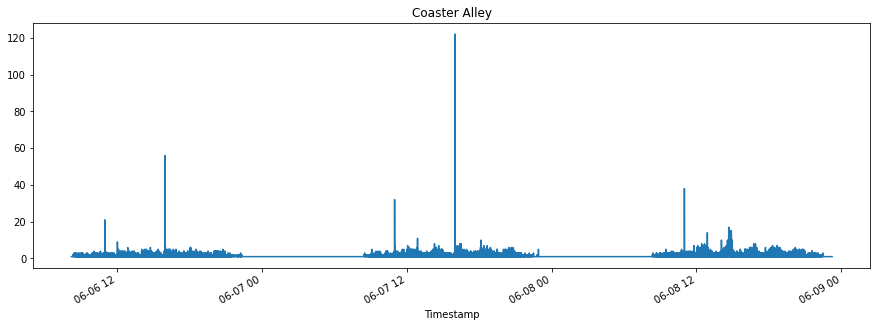

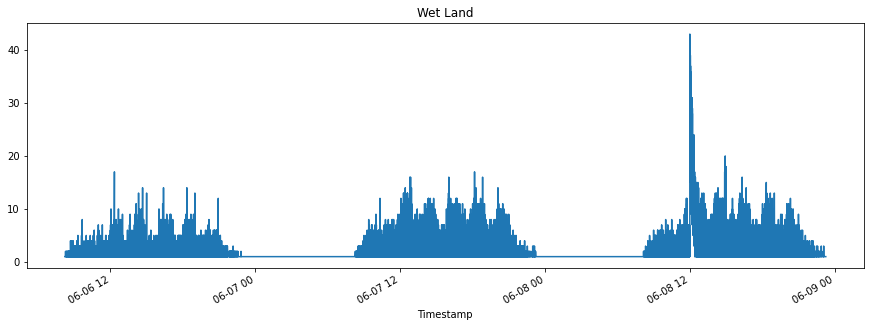

In [29]:
for location in df_comm['location'].unique():
    plt.subplots(figsize=(15, 5))
    df_comm[df_comm['location']==location][['Timestamp', 'from']].drop_duplicates().groupby(by=['Timestamp'])['from'].count().plot()
    plt.title(location)
    plt.show()

In [30]:
def plot_number_of_parkgoers(loc=None):
    if loc == None:
        count_in = df_move.groupby('Timestamp')['Timestamp'].count()
        count_out = df_move.groupby('next_Timestamp')['next_Timestamp'].count()
        suf=''
    else:
        count_in = df_move[df_move['dino_loc']==loc].groupby('Timestamp')['Timestamp'].count()
        count_out = df_move[df_move['dino_loc']==loc].groupby('next_Timestamp')['next_Timestamp'].count()
        suf=' at '+str(loc)
    count = pd.concat([count_in, count_out], axis=1).fillna(0).cumsum()
    count['Total'] = count['Timestamp'] - count['next_Timestamp']
    plt.subplots(figsize=(15, 5))
    count['Total'].plot()
    plt.title('Number of parkgoers'+suf)
    plt.show()

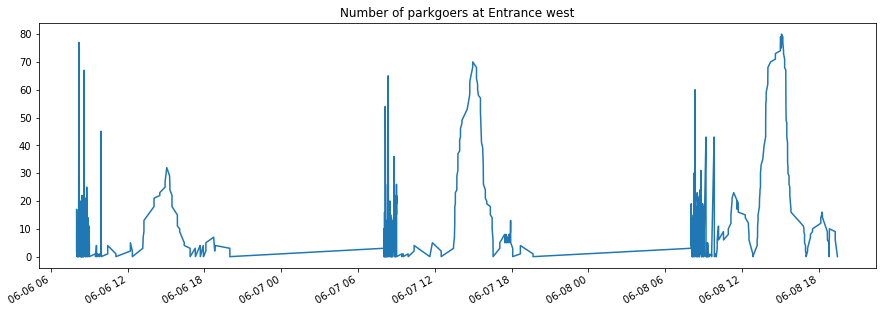

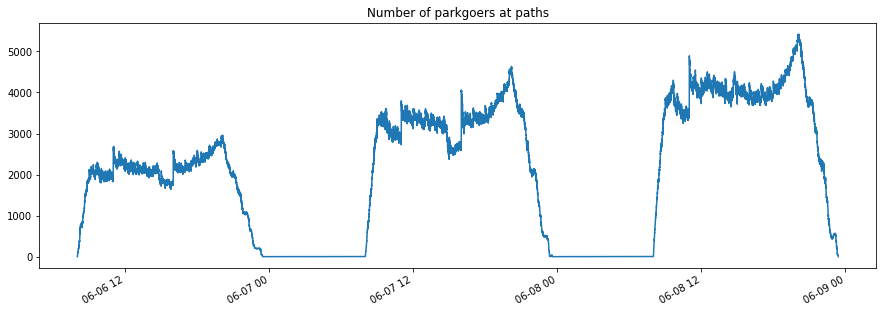

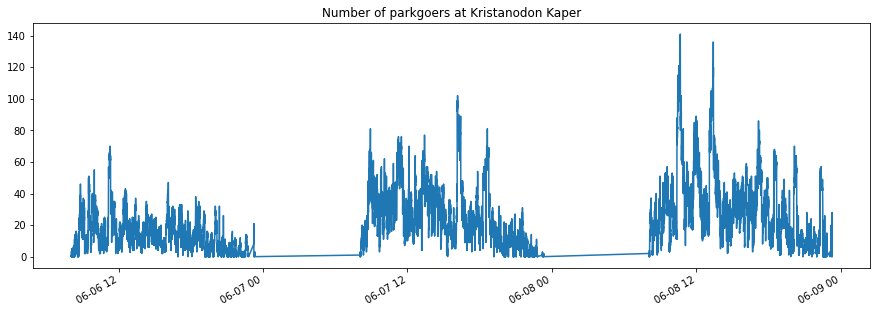

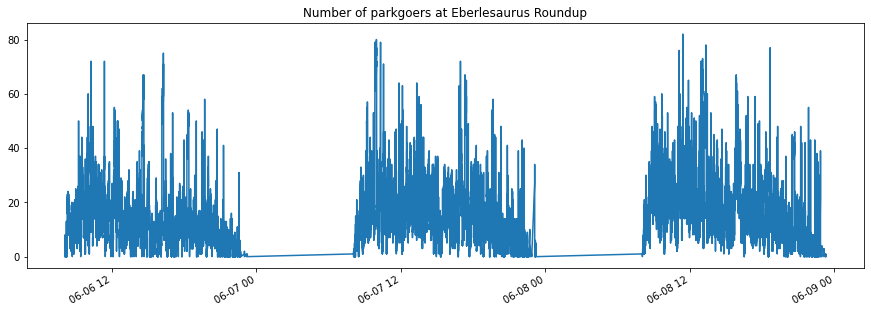

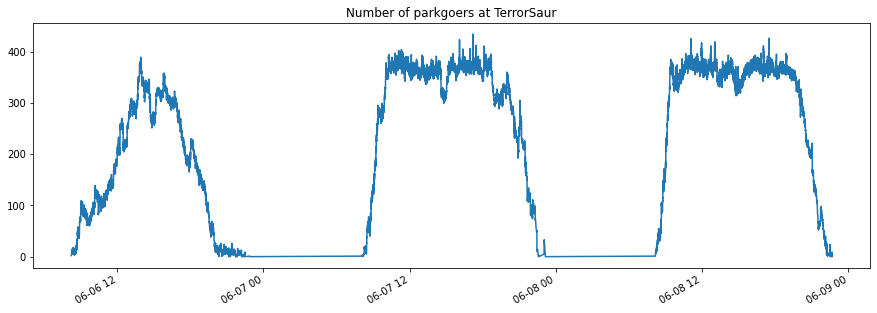

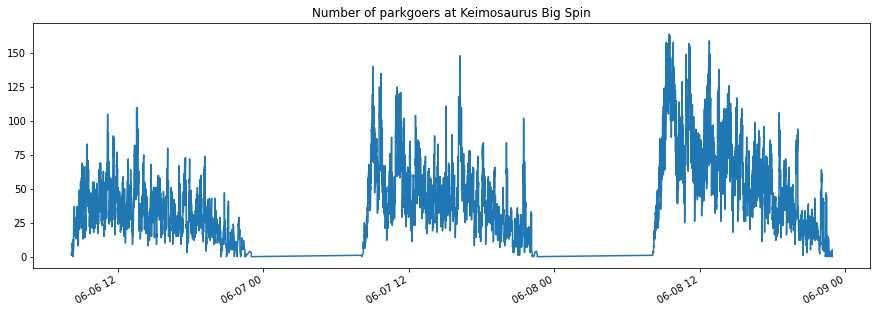

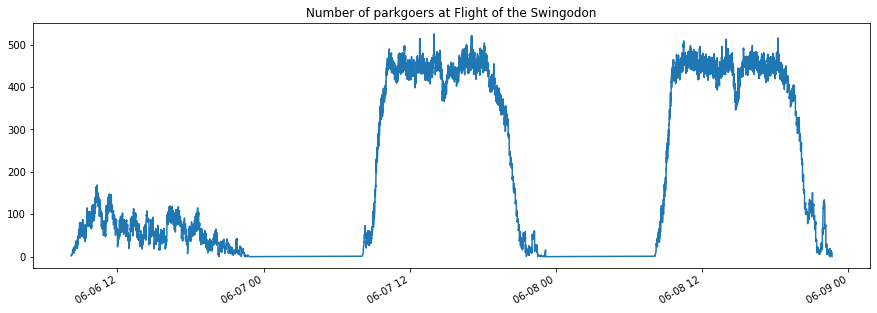

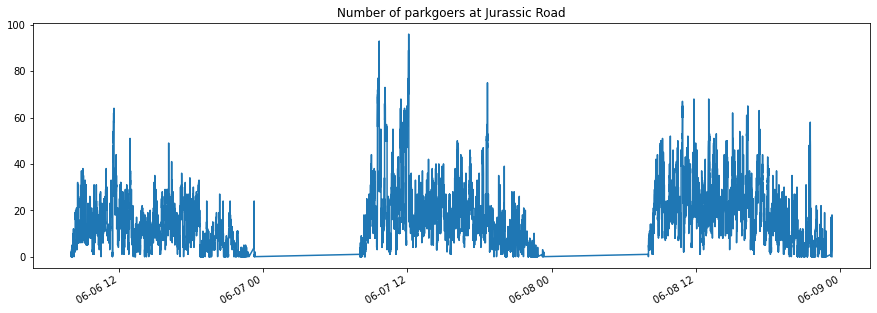

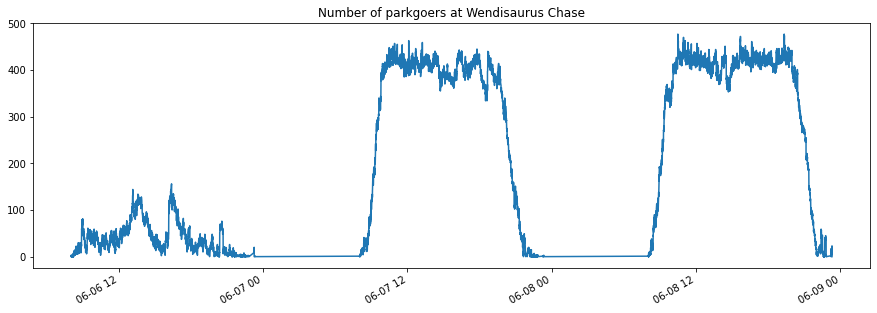

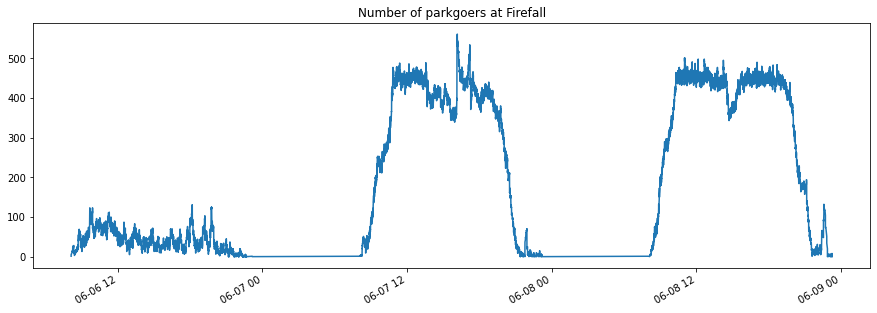

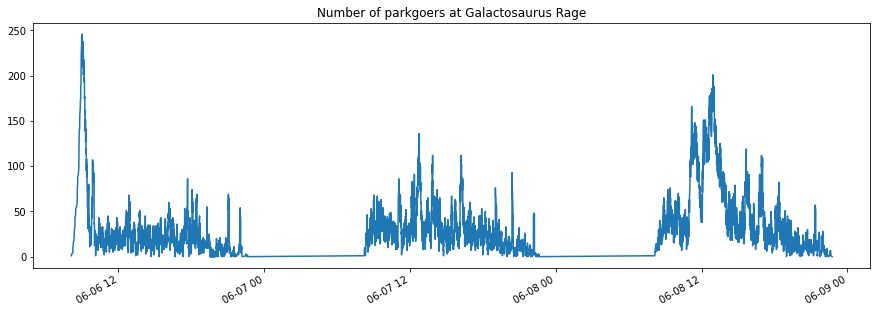

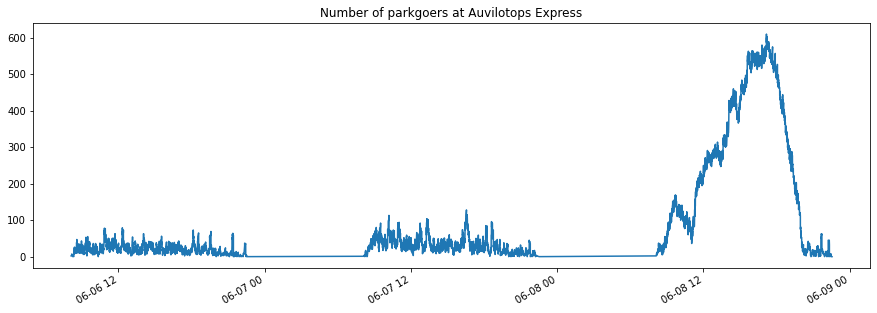

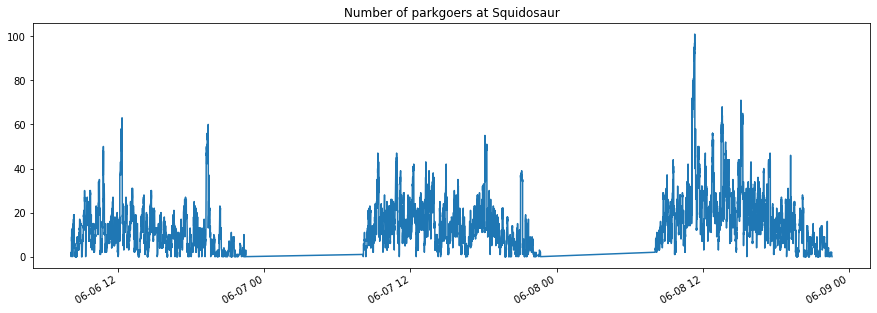

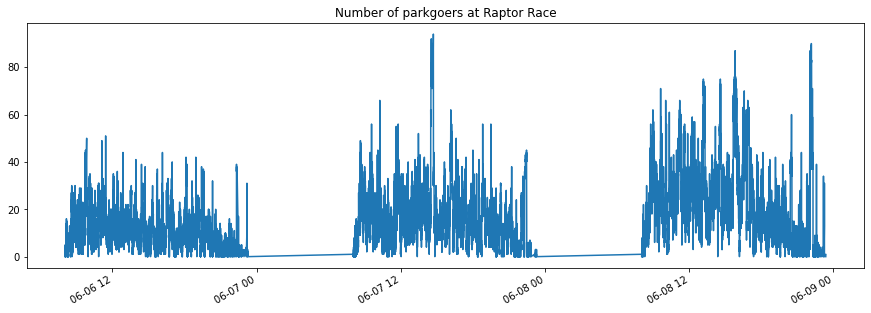

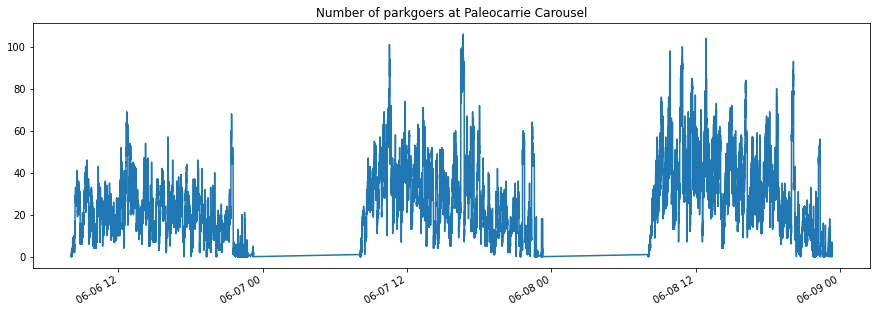

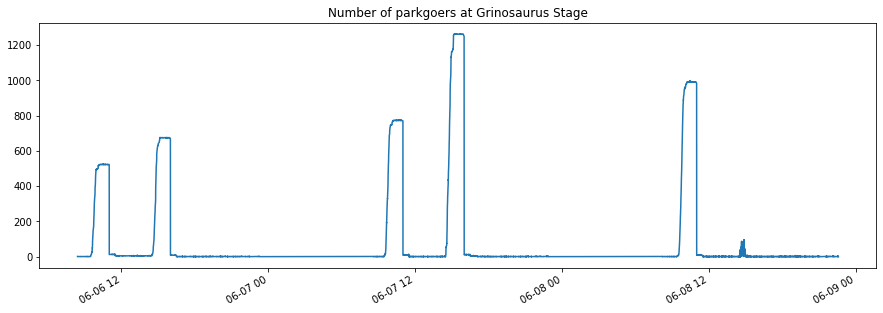

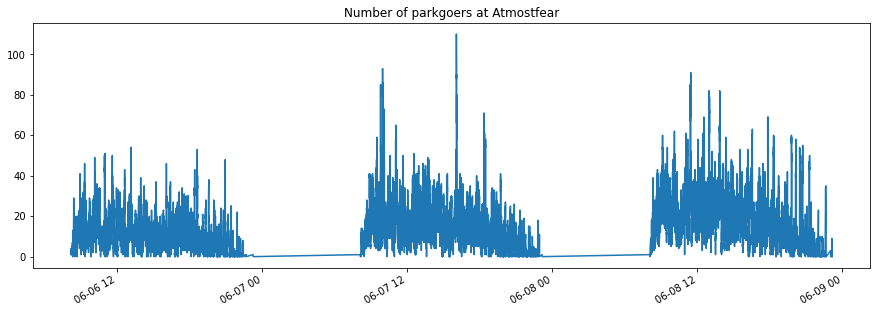

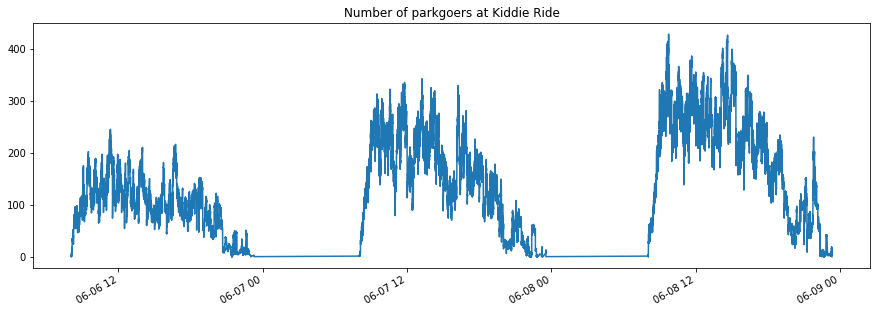

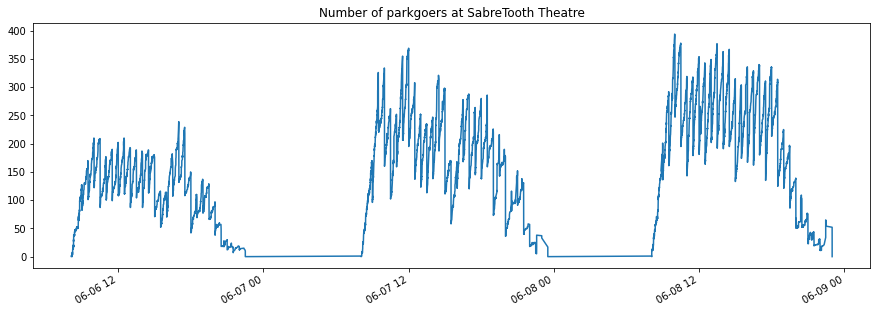

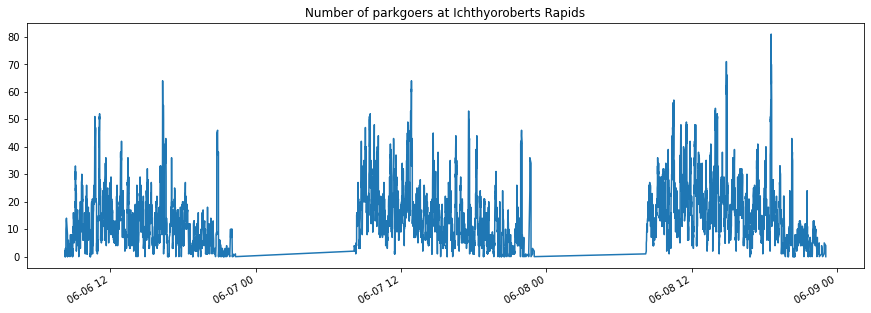

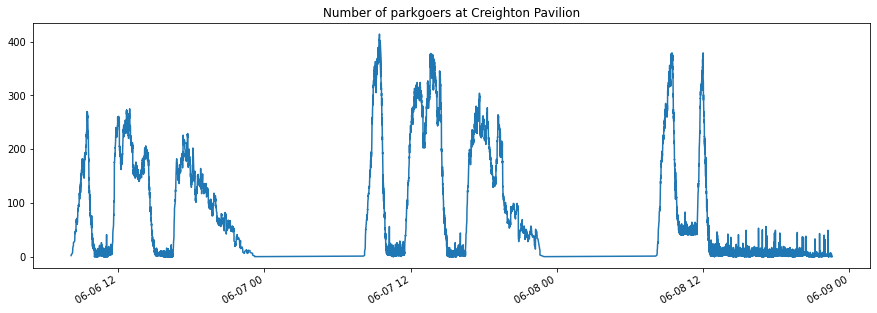

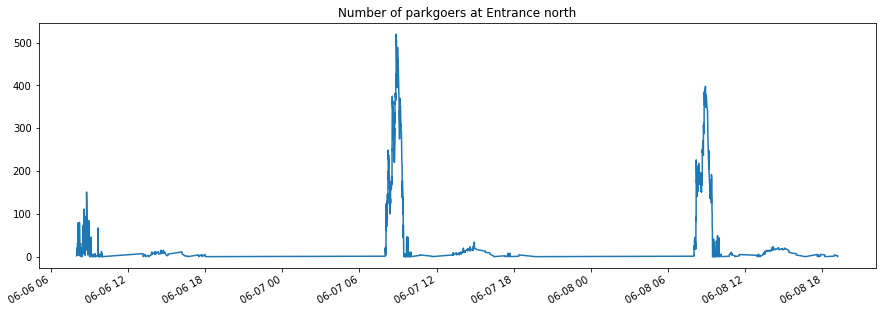

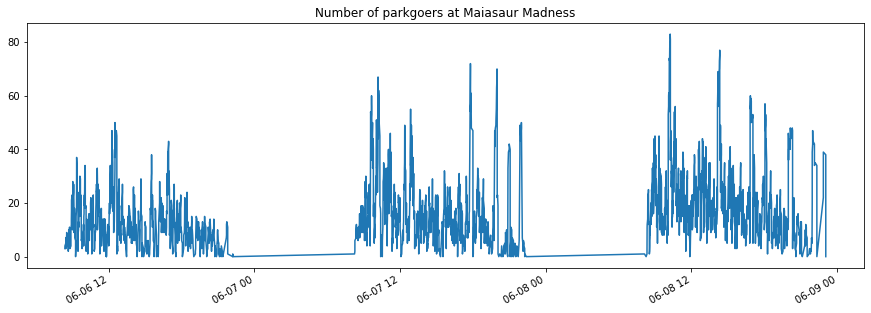

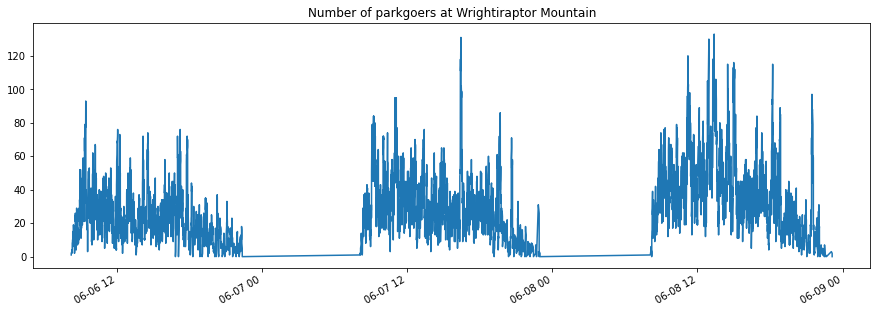

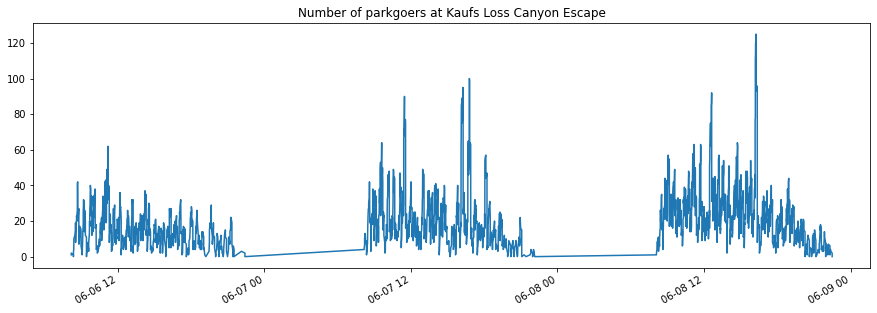

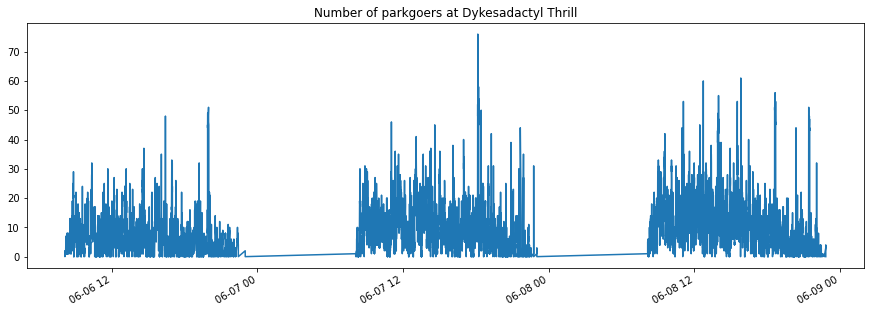

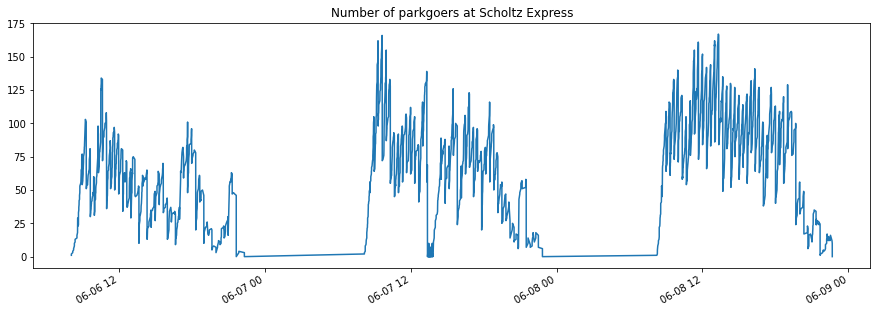

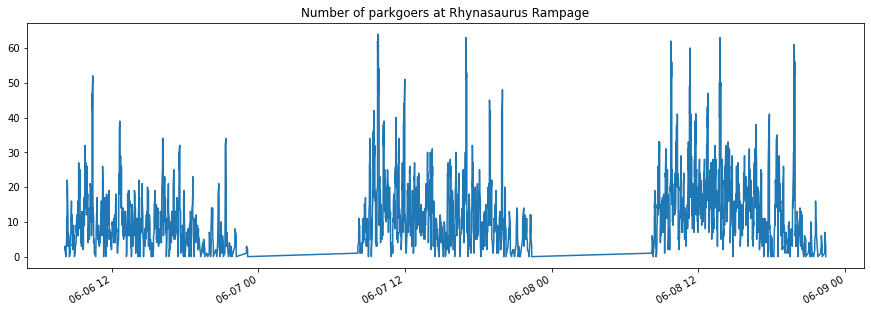

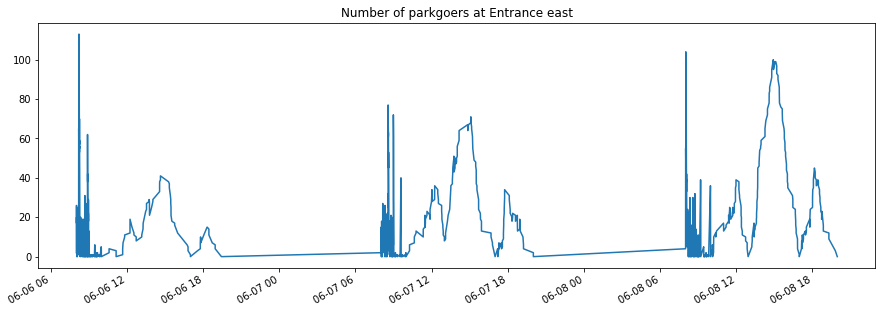

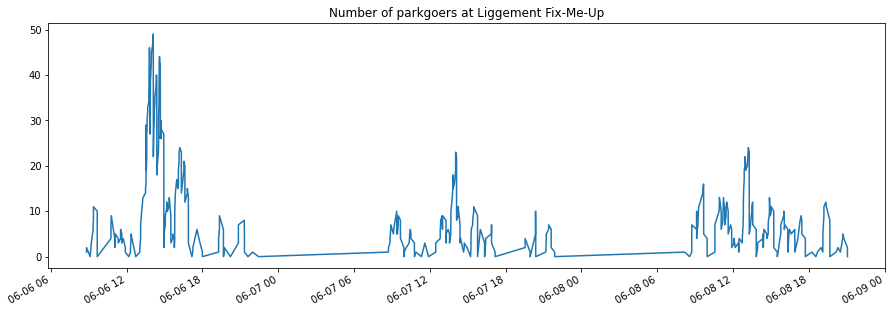

In [31]:
for loc in df_move['dino_loc'].unique():
    plot_number_of_parkgoers(loc)

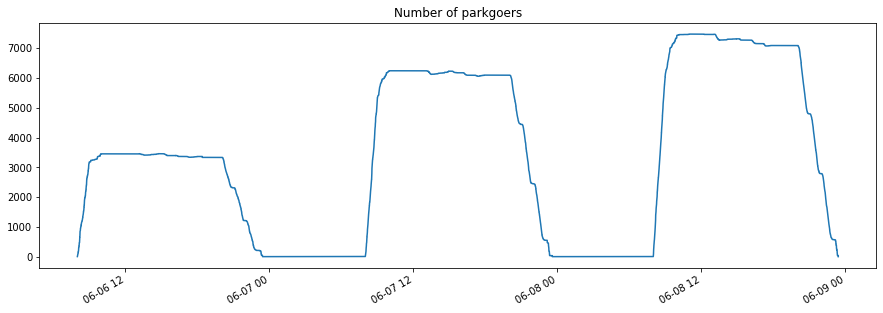

In [32]:
plot_number_of_parkgoers()

In [2]:
import gif

In [49]:
pax = 1983765

@gif.frame
def plot_gif_map(date, timestamp):
    df_gif_map = df_pax[(df_pax['Date']==date)&(df_pax['Timestamp']<=timestamp)]
    timestamp_max = df_gif_map['Timestamp'].max()
    fig, ax = plt.subplots(figsize=(10, 8))
    df_gif_map_max = df_gif_map[df_gif_map['Timestamp']==timestamp_max].copy()[['X', 'Y']].drop_duplicates()
    df_gif_map = df_gif_map[df_gif_map['Timestamp']!=timestamp_max][['X', 'Y']].drop_duplicates()
    
    # draw park map in grayscale
    fname = 'Park Map.jpg'
    image = Image.open(fname).convert("L")
    arr = np.asarray(image)
    ax.imshow(arr, cmap='gray', extent=[0, 100, 0, 100])

    ax.scatter(df_gif_map['X'], df_gif_map['Y'])
    ax.scatter(df_gif_map_max['X'], df_gif_map_max['Y'], c='r')
    ax.set_title('Location of '+str(pax)+' at '+str(timestamp))

frames=[]
df_pax = df_move[df_move['id']==pax]     
for date in df_pax['Date'].unique():
    for timestamp in tqdm(df_pax[df_pax['Date']==date]['Timestamp'].dt.floor('min').unique()):
        frame = plot_gif_map(date, timestamp)
        frames.append(frame)

gif.save(frames, str(pax)+'.gif', duration=len(frames))

100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:34<00:00,  1.08it/s]
